In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, set the seed for reproducibility of results

In [2]:
seed = 42
np.random.seed(seed)

Loading data into a pandas dataframe

In [3]:
dataframe = pd.read_csv('recs2009_public.csv')
kwh = dataframe['KWH']
df_drop = dataframe.drop('KWH', axis=1, inplace=False)

# Data visualization

Let's see if the dataframe loaded properly. This will also give us an idea of what the data looks like. Each row is a single example and each column is a single feature.

In [4]:
dataframe.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


By looking at the data documentation, we can also make a list of the features that are categorical(discrete) and those that are numerical(continuous). This will be useful when preprocessing the data. When loading the dataframe, pandas is unable to tell if a given feature is categorical with discrete numerical values or if it should be numerical, so we have to go through the features and specify whether or not they are categorical.

In [5]:
# All the features NOT in this list are categorical
num_features = ['NWEIGHT', 'HDD65', 'CDD65', 'HDD30YR', 'CDD30YR', 'TOTHSQFT', 'TOTUSQFT', 'TOTCSQFT', 'TOTUCSQFT', 'KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHOTH', 'BTUEL', 'BTUELSPH', 'BTUELCOL', 'BTUELWTH', 'BTUELRFG', 'BTUELOTH', 'DOLLAREL', 'DOLELSPH', 'DOLELCOL', 'DOLELWTH', 'DOLELRFG', 'DOLELOTH', 'CUFEETNG', 'CUFEETNGSPH', 'CUFEETNGWTH', 'CUFEETNGOTH', 'BTUNG', 'BTUNGSPH', 'BTUNGWTH', 'BTUNGOTH', 'DOLLARNG','DOLNGSPH','DOLNGWTH','DOLNGOTH','GALLONLP','GALLONLPSPH','GALLONLPWTH','GALLONLPOTH','BTULP','BTULPSPH','BTULPWTH','BTULPOTH','DOLLARLP','DOLLPSPH','DOLLPWTH','DOLLPOTH','GALLONFO','GALLONFOSPH','GALLONFOWTH','GALLONFOOTH','BTUFO','BTUFOSPH','BTUFOWTH','BTUFOOTH','DOLLARFO','DOLFOSPH','DOLFOWTH','DOLFOOTH','GALLONKER','GALLONKERSPH','GALLONKERWTH','GALLONKEROTH','BTUKER','BTUKERSPH','BTUKERWTH','BTUKEROTH','DOLLARKER','DOLKERSPH','DOLKERWTH','DOLKEROTH','BTUWOOD','CORDSWD','TOTALBTU','TOTALBTUSPH','TOTALBTUCOL','TOTALBTUWTH','TOTALBTURFG','TOTALBTUOTH','TOTALDOL','TOTALDOLSPH','TOTALDOLCOL','TOTALDOLWTH','TOTALDOLRFG','TOTALDOLOTH','HDD50','CDD80','GND_HDD65','WSF','OA_LAT','GWT','DesignDBT99','DesignDBT1']

for col in df_drop.columns:
    if col not in num_features:
        df_drop[col] = df_drop[col].astype('category')


We can visualize some info about the KWH variable we want to predict.
We see that the minimum is larger than zero, which means we won't have to worry about this during training.

We can also look at the data distribution. We see that, as expected, the distribution isn't a perfect normal distribution and is in fact positively skewed.


In [6]:
print(kwh.describe())

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64


Skewness: 2.114188


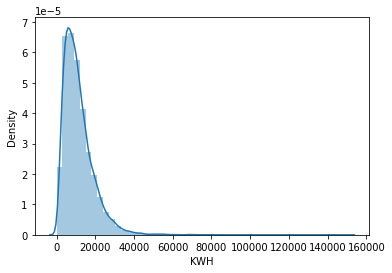

In [7]:
sns.distplot(kwh)

print("Skewness: %f" % kwh.skew())

Before diving into the problem itself, let's have a closer look at the data we have. We can intuitively identify a few variables from the data that would likely have an influence on the energy consumption. 
Using those variables, we can see how they affect the energy consumption. If this was a real project, I'd look more in depth into more variables.

TYPEHUQ: Type of Housing Unit - Instinctively, some types of houses should have a higher energy consumption because of size and proximity to other units.

TOTROOMS: Total number of rooms - If a house has more rooms, it takes more energy to cool or heat, which drives energy consumption up.

In [ ]:
param = 'TYPEHUQ'
data = pd.concat([kwh, dataframe[param]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=param, y="KWH", data=data)
fig.axis(ymin=0, ymax=160000)

param = 'TOTROOMS'
data = pd.concat([kwh, dataframe[param]], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x=param, y="KWH", data=data)
fig.axis(ymin=0, ymax=160000)

[TYPEHUQ] It seems that the type of housing #2(single-family detached) generally has a higher energy consumption than the other types. This makes sense: attached homes or apartment building tend to share heat with one another.

[TOTROOMS] It also seems like the energy consumption tends to slowly go up with the total number of rooms in the building, which also instinctively makes sense.

Now that we looked intuitively at the data, let's look at the more 'mathematical' side of things by looking at the correlation between the different features

In the following heatmap, the squares close to white are highly correlated, which means they mostly tell us the same information.
If we wanted to reduce the number of input features, would would take this into consideration.

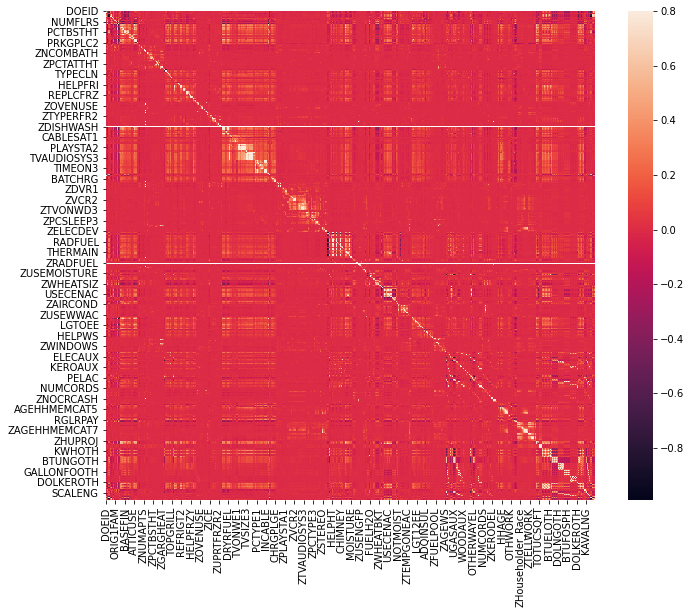

In [9]:
correlation = dataframe.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation, vmax=.8, square=True);

The correlation map gives interesting information, but in this case it's hard to interpret because we have many (940) features. Let's look specifically at the 10 features most highly correlated to our KWH



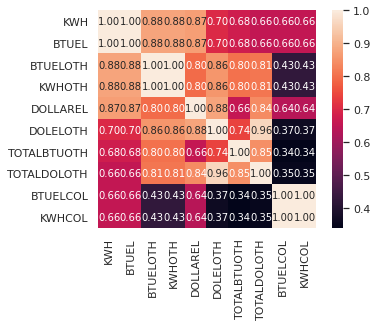

In [10]:
topk = 10
cols = correlation.nlargest(topk, 'KWH')['KWH'].index
corrmat = np.corrcoef(dataframe[cols].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)

We see that BTUEL is 100% correlated with KWH. This makes sense: they are basically a different way of presenting the KWH. Theoretically, we could probably learn to predict the energy consumption using only the BTUEL feature with a decent accuracy, but that's cheating.

We also see that some other features basically show the exact same information with a 100% correlation (e.g. BTUELCOL, KWHCOL, TOTALBTUCOL). 
Again, we could keep only one of those and not lose much information.

The features with the highest correlation to KWH are: BTUEL, BTUELOTH, KWHOTH, DOLLAREL, DOLELOTH. Let's look at them closer.

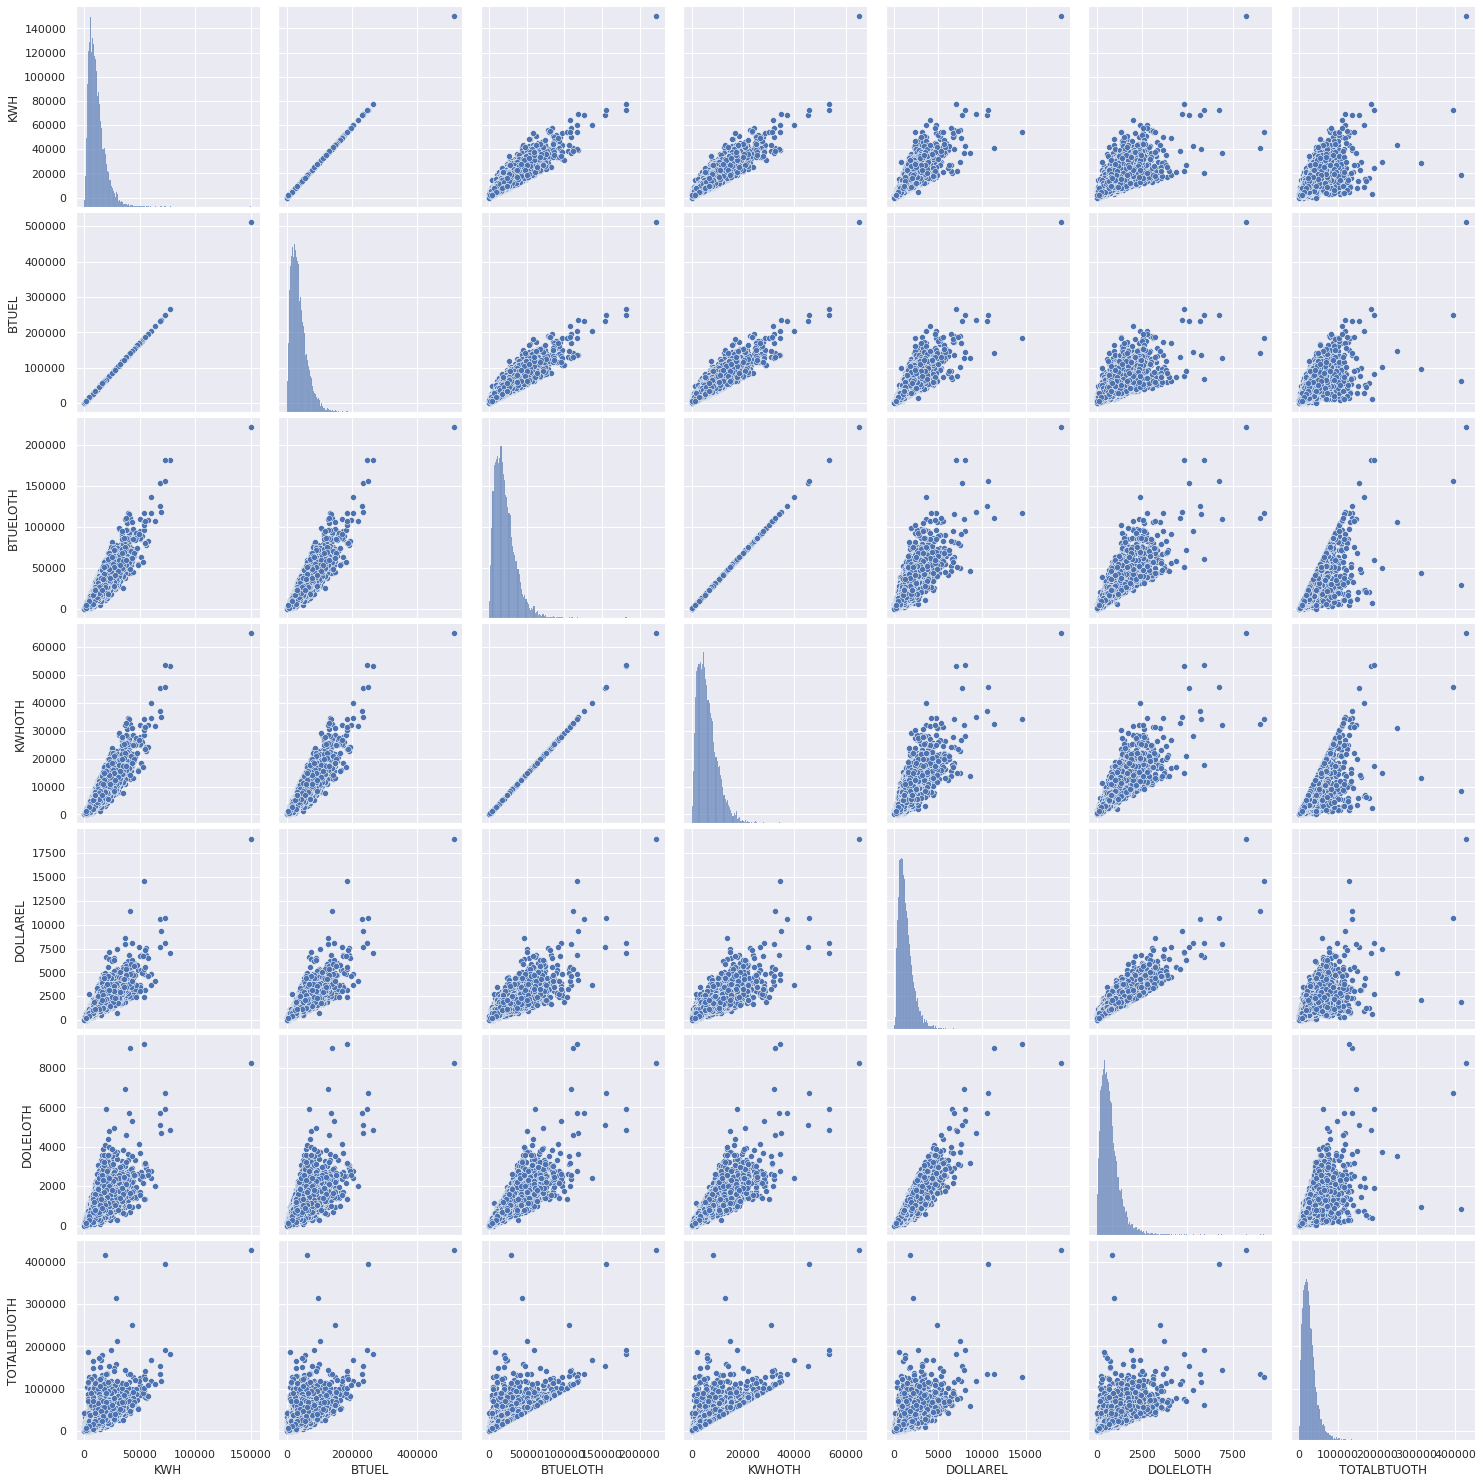

In [11]:
sns.set()
columns = ['KWH', 'BTUEL', 'BTUELOTH', 'KWHOTH', 'DOLLAREL', 'DOLELOTH', 'TOTALBTUOTH']
sns.pairplot(dataframe[columns], size=3.0)

We can see some pretty strong correlations and obvious trends. In many cases, we see a generally linear tendency. We can also see something interesting on some pairs, such as BTUELOTH/TOTALBTUOTH or KWHOTH/TOTALBTUOTH. It seems like there is a hard line/frontier.

BTUELOTH is defined as "Electricity usage for other purposes (all end-uses except Space Heating (SPH), Air Conditioning(COL), Water Heating (WTH), and Refrigerators (RFG)), in thousand BTU, 2009"

TOTALBTUOTH is defined as "Total usage for appliances, electronics, lighting, and miscellaneous uses, in thousand BTU, 2009"

Knowing this, the frontier we observe makes sense: They both represent the electricity usage for smaller appliances and electronics. If the BTUELOTH rises, then the TOTALBTUOTH *HAS* to go up, since the BTUELOTH is a subset of the TOTALBTUOTH. This explains the hard delimitation.

# Data preprocessing

Now that we have a better idea of what the data actually looks like, we can move on to preprocessing.

## Missing data

First, see if there's any missing data

In [12]:
total = dataframe.isnull().sum().sort_values(ascending=False)
percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10)) #

         Total  Percent
DOEID        0      0.0
ZPOOL        0      0.0
DRAFTY       0      0.0
INSTLWS      0      0.0
AGEWS        0      0.0
HELPWS       0      0.0
HELPWSY      0      0.0
AUDIT        0      0.0
AGEAUD       0      0.0
HELPAUD      0      0.0


It seems there is no missing data, so we don't have any NaNs to replace! This is a good dataset.

## Outliers

Second, let's look at outliers. Start by scaling the KWH and look at how different the lows and highs are. The scaling let's us have a better intuition of whether or not a datapoint in an outlier

In [13]:
kwh_scaled = StandardScaler().fit_transform(kwh[:,np.newaxis]);
low_range = kwh_scaled[kwh_scaled[:,0].argsort()][:10]
high_range= kwh_scaled[kwh_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)


outer range (low) of the distribution:
[[-1.47511377]
 [-1.47079489]
 [-1.46857002]
 [-1.46503639]
 [-1.46451289]
 [-1.43362637]
 [-1.42197849]
 [-1.41818311]
 [-1.41818311]
 [-1.40561911]]

outer range (high) of the distribution:
[[ 6.36103102]
 [ 6.39911566]
 [ 6.92902882]
 [ 7.45998898]
 [ 7.47216036]
 [ 7.55395728]
 [ 8.04055078]
 [ 8.05887329]
 [ 8.681446  ]
 [18.18716405]]


The lows are all pretty similar, and the highs too (with the exception of one value in the 18s, while the others are 7-8s). If we look in more details at a scatter plot, we can try to spot the outliers.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


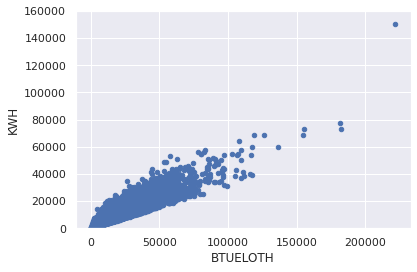

In [14]:
var = 'BTUELOTH'
data = pd.concat([kwh, dataframe[var]], axis=1)
data.plot.scatter(x=var, y='KWH', ylim=(0,160000));

We see that one data point is very far from the others, probably the point corresponding to the 18 seen previously.
However, it still seems to be linearly correlated so we keep it. If this was a real project I would look more in depth at outliers, but in this case it seems like we have no clear outlier to remove. Again, this seems to be a good dataset!


## Data engineering

Let's go back to our KWH variable. 

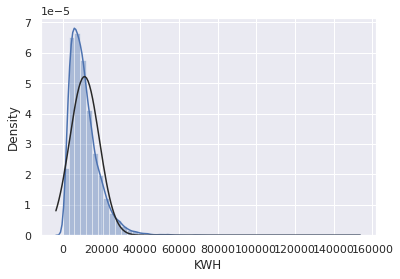

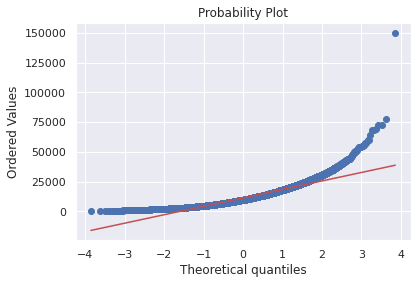

In [15]:
sns.distplot(kwh, fit=norm)
fig = plt.figure()
res = stats.probplot(kwh, plot=plt)

We saw that the distribution is not perfectly normal. Machine learning algorithms tend to learn better when the data follows a gaussian distribution because of the Central Limit Theorem, so let's try a simple log transformation to correct the distribution. We could also try more complex transformations such as a Box Cox transformation.

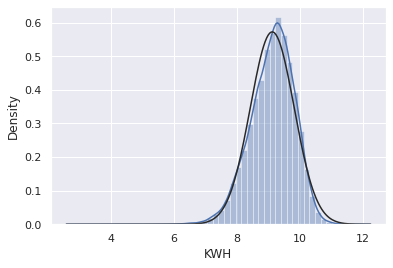

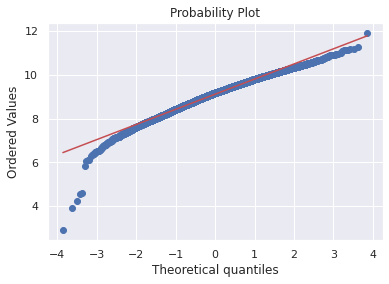

In [43]:
log_kwh = np.log1p(kwh)
sns.distplot(log_kwh, fit=norm)
fig = plt.figure()
res = stats.probplot(log_kwh, plot=plt)

It seems to have helped a lot! Our distribution is now a lot closer to a normal distribution.

Let's now transform the features with a skewness higher than 0.75.

In [44]:
skewed_features = df_drop[num_features].apply(lambda x: skew(x))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index
print("Number of skewed features to correct: ", skewed_features.shape[0])
df_drop[skewed_features] = np.log1p(df_drop[skewed_features])

Number of skewed features to correct:  38


We can now transform the categorical features into one-hot vectors.

In [45]:
df_drop = pd.get_dummies(df_drop)

Split the data into train/val/test sets. We could instead use K-folds cross-validation, but I prefer having separate sets in case I need to go to deep learning models.

In [46]:
log_kwh = log_kwh.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(df_drop, log_kwh, test_size=0.2, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed) # 0.5 x 0.2 = 0.1

We also need to scale the numerical features to compensate for a possible scale imbalance between them. We could also normalize them with different methods, but MinMax scaling should be enough for this specific problem. We make sure to fit the scaler on the training data only to avoid leaking information from the val/test sets.

In [47]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)
y_val = y_scaler.transform(y_val)

scaler = MinMaxScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])

# Models

## Exploration

Now that the data has been preprocessed, we can move on to the actual models. Let's test a few simple machine learning models and see how they perform. Since we have features with a very high correlation and what seems like a linear tendency, simple models should be sufficient to get a decent performance.

In [48]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_percentage_error

def rmse_val(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    preds_rescaled = y_scaler.inverse_transform(preds.reshape(-1,1))
    back_pred = np.expm1(preds_rescaled)
    y_val_gt = kwh[X_val.index]
    rmse = np.sqrt(mean_squared_error(y_val_gt, back_pred))
    mape = mean_absolute_percentage_error(y_val_gt, back_pred)
    return rmse, mape, model

In [49]:
linreg = LinearRegression()
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=seed)
lasso = Lasso(alpha =0.0005, random_state=seed)
BR = BayesianRidge()
lassoLIC = LassoLarsIC()
poissonR = PoissonRegressor()

forest = RandomForestRegressor(random_state=seed)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =seed)

svr = SVR()

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)



In [50]:
rmse, mape, linreg_trained = rmse_val(linreg)
print("\nlinreg score: {:.4f} ({:.4f})\n".format(rmse, mape))


linreg score: 638.1196 (0.0373)



In [23]:
rmse, mape, ENet_trained = rmse_val(ENet)
print("\nENet score: {:.4f} ({:.4f})\n".format(rmse, mape))


ENet score: 945.5641 (0.0554)



In [24]:
rmse, mape, lasso_trained = rmse_val(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(rmse, mape))


Lasso score: 945.8931 (0.0535)



In [25]:
rmse, mape, lassoLIC_trained = rmse_val(lassoLIC)
print("\nlassoLIC score: {:.4f} ({:.4f})\n".format(rmse, mape))


lassoLIC score: 6.9490 (0.0003)



In [26]:
rmse, mape, poissonR_trained = rmse_val(poissonR)
print("\npoissonR score: {:.4f} ({:.4f})\n".format(rmse, mape))


poissonR score: 4522.7179 (0.4165)



In [27]:
rmse, mape, forest_trained= rmse_val(forest)
print("\nforest score: {:.4f} ({:.4f})\n".format(rmse, mape))


forest score: 38.3924 (0.0008)



In [28]:
rmse, mape, GBoost_trained = rmse_val(GBoost)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(rmse, mape))


GBoost score: 1131.9563 (0.0706)



In [29]:
rmse, mape, svr_trained = rmse_val(svr)
print("\nsvr score: {:.4f} ({:.4f})\n".format(rmse, mape))


svr score: 4876.4715 (0.3453)



In [30]:
rmse, mape, KRR_trained = rmse_val(KRR)
print("\nKRR score: {:.4f} ({:.4f})\n".format(rmse, mape))


KRR score: 3928.4798 (0.3434)



It seems that the following models give the best performance:
1. Lasso model fit with Lars using AIC 
2. Random Forest regressor

with the basic Linear Regression, Lasso, ElasticNet, and GradientBoostingRegressor also giving an okay performance. When predicting, some of these models might overshoot, while some others might undershoot. If we combine them, it might be possible to get an overall better performance than what we would get with individual models. (These cells take a while to run)

In [51]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [34]:
averaged_models = AveragingModels(models = (lassoLIC, forest))
rmse, mape, _ = rmse_val(averaged_models)
print("\n Averaged (lassoLIC+forest) score: {:.4f} ({:.4f})\n".format(rmse, mape))


 Averaged (lassoLIC+forest) score: 20.5141 (0.0005)



In [52]:
averaged_models = AveragingModels(models = (linreg, lasso, ENet, GBoost, lassoLIC, forest))
rmse, mape, _ = rmse_val(averaged_models)
print("\n Averaged (lasso, ENet, GBoost, lassoLIC, forest) score: {:.4f} ({:.4f})\n".format(rmse, mape))


 Averaged (lasso, ENet, GBoost, lassoLIC, forest) score: 463.4485 (0.0269)



In this case, it seems like the performance with LassoLarsIC is good enough that averaging models doesn't help the performance. This is mostly due to the fact that the performance for our other models is orders of magnitude higher.

It seems we can get good results with the simple machine learning algorithms. If this was a real project, I would definitely spend more time fine-tuning the models' hyperparameters. Also, when combining predictions from multiple models, I would also try other techniques to combine them, like a weighted average.


If the performance was still not good enough, I would likely move on to a simple feed-forward neural net (which is when the train/val/test split comes into play). If this still doesn't give decent results, I would try more complex architectures.

## Solution summary
In short, the proposed suggestion is:
1. log-transform the numerical features and the target energy consumption
2. Scale numerical features with a MinMaxScaler. The scaler is fit on the training data only.
3. One-hot encode the categorical features.
4. Use a Lasso model fit with Lars using AIC.


Let's see how the model does on the test set, which has not been seen before.

In [53]:
preds = lassoLIC_trained.predict(X_test)
preds_rescaled = y_scaler.inverse_transform(preds.reshape(-1,1))
back_pred = np.expm1(preds_rescaled)
y_test_gt = kwh[X_test.index]
rmse = np.sqrt(mean_squared_error(y_test_gt, back_pred))
mape = mean_absolute_percentage_error(y_test_gt, back_pred)

print("Root-mean-squared-error: ", rmse)
print("Mean Absolute Percentage Error: ", mape)

print("Prediction: ")
print(back_pred[0:5])
print("Expected: ")
print(y_test_gt[0:5])

Root-mean-squared-error:  7.5195391360417165
Mean Absolute Percentage Error:  0.0003389139356477305
Prediction: 
[[ 4657.07275769]
 [ 2389.88019628]
 [24144.22448888]
 [ 4449.00664359]
 [14234.27742986]]
Expected: 
2534     4655
9113     2388
4561    24159
7845     4447
1350    14238
Name: KWH, dtype: int64


It seems like our simple model does a pretty good job.

## Taking the solution a step further - Discussion

In the proposed solution, every feature present in the dataset was used. However, there may be cases where we don't want to use all of them. For example:

1. If we have features with very little variance (e.g. almost all the samples have a similar value)
2. If multiple features give us the same or very similar information
3. If we have too many features, it can be hard for the simple models to learn. Having more features takes the solution space to a higher dimensional space, which can be harder to optimize.

If this was an actual problem I was working on, I would definitely push the feature selection further than I did in this notebook. I would probably treat the number of features to keep as a tunable hyper-parameter and try different values and feature selection methods.

## For fun: Leveraging the very high correlation between KWH and BTUEL
As we saw earlier, the BTUEL variable has a pretty much 100% correlation with KWH. This means that a simple linear regression should let us predict the KWH from BTUEL. Let's test this quickly

In [54]:
#Load data
btuel = dataframe['BTUEL']
kwh = dataframe['KWH']

#Process and split
log_kwh = np.log1p(kwh)
log_kwh = log_kwh.values.reshape(-1, 1)

log_btuel = np.log1p(btuel)
log_btuel = log_btuel.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(log_btuel, log_kwh, test_size=0.2, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=seed) # 0.5 x 0.2 = 0.1

from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)
y_val = y_scaler.transform(y_val)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#Linear model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_percentage_error

def rmse_val(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    preds_rescaled = y_scaler.inverse_transform(preds.reshape(-1,1))
    back_pred = np.expm1(preds_rescaled)
    
    y_val_gt = y_scaler.inverse_transform(y_val.reshape(-1,1))
    y_val_gt = np.expm1(y_val_gt)
    
    rmse = np.sqrt(mean_squared_error(y_val_gt, back_pred))
    mape = mean_absolute_percentage_error(y_val_gt, back_pred)
    return rmse, mape, model

linreg = LinearRegression()

rmse, mape, linreg_trained = rmse_val(linreg)
print("\nlinreg score: {:.4f} ({:.4f})\n".format(rmse, mape))

test_preds = linreg_trained.predict(X_test)
test_preds_rescaled = y_scaler.inverse_transform(test_preds.reshape(-1,1))
back_test = np.expm1(test_preds_rescaled)
    
y_test_gt = y_scaler.inverse_transform(y_test.reshape(-1,1))
y_test_gt = np.expm1(y_test_gt)

rmse = np.sqrt(mean_squared_error(y_test_gt, back_test))
mape = mean_absolute_percentage_error(y_test_gt, back_test)

print("Root-mean-squared-error: ", rmse)
print("Mean Absolute Percentage Error: ", mape)

print("Prediction: ")
print(back_test[0:5])
print("Expected: ")
print(y_test_gt[0:5])


linreg score: 1.3204 (0.0001)

Root-mean-squared-error:  1.4756652887264257
Mean Absolute Percentage Error:  5.99323323604868e-05
Prediction: 
[[ 4655.44812636]
 [ 2388.21951534]
 [24156.41607356]
 [ 4447.34912679]
 [14237.56185276]]
Expected: 
[[ 4655.]
 [ 2388.]
 [24159.]
 [ 4447.]
 [14238.]]


This simple linear model with a single feature does an even better job than the more complex model we had previously. This showcases that we don't necessarily need to use every single feature we have in the data, and that complex models aren't always necessary. However, in most projects, we won't have features with such a high correlation as this with the value we wish to predict.